In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier
from joblib import dump, load
import os

print(torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Not detected")

# Set GPU Support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
file_path = "rotten_tomatoes_critic_reviews.csv"
# For fast test
# file_path = "sampled_data.csv"
data = pd.read_csv(file_path)



2.5.1
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 2060
Using device: cuda


In [2]:
# Initialize BERT
bert_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_name)
bert = BertModel.from_pretrained(bert_name).to("cuda" if torch.cuda.is_available() else "cpu")
bert.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [3]:
#  Normalize score
def normalize_score(score):
    score = str(score).strip()

    # Handle x/y format
    if "/" in score:
        try:
            num, denom = map(float, score.split("/"))
            if denom == 0:
                return np.nan
            return (num / denom) * 10
        except:
            return np.nan

    # Letter grade to number
    letter_grades = {
        "A+": 10, "A": 9, "A-": 8.5,
        "B+": 8, "B": 7, "B-": 6.5,
        "C+": 6, "C": 5, "C-": 4.5,
        "D+": 4, "D": 3, "D-": 2.5,
        "F": 0
    }
    if score.upper() in letter_grades:
        return letter_grades[score.upper()]

    # Digital direct convert
    try:
        val = float(score)
        if val > 50:       # Assume percentage out of 100
            return val / 10
        elif val > 10:     # Assume out of 20
            return val / 20 * 10
        return val
    except:
        return np.nan


#  BERT Embedding with Filtering
def get_bert_embeddings(texts, batch_size=32, max_len=256):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    embeddings, valid_indices, skipped_batches = [], [], []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="ERT", leave=True, ncols=100):
            batch = texts[i:i+batch_size]
            try:
                tokens = tokenizer(batch.tolist(), padding=True, truncation=True,
                                   return_tensors="pt", max_length=max_len).to(device)
                outputs = bert(**tokens)
                mean_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
                embeddings.append(mean_embeddings)
                valid_indices.extend(batch.index)
            except Exception as e:
                print(f"Skipped batch {i}: {e}")
                skipped_batches.append(i)

    if not embeddings:
        raise ValueError("No valid BERT embeddings were generated.")

    return np.vstack(embeddings), valid_indices, skipped_batches


# Clean + BERT Pipeline
def full_data_pipeline(data, sample_frac=0.4):
    print("\nInitial Data Shape:", data.shape)

    # Step 1: Sampling
    data = data.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
    print("After Sampling:", data.shape)

    # Step 2: Clean fields
    data = data.dropna(subset=["review_content", "review_type", "top_critic"])
    data = data[data["review_score"].notna() & (data["review_score"] != "")]
    print("After Dropping NaNs and Empty Scores:", data.shape)

    # Step 3: Normalize fields
    data["sentiment"] = data["review_type"].map({"Fresh": 1, "Rotten": 0})
    data["is_critic"] = data["top_critic"].astype(str).str.lower().map({"true": 1, "false": 0})
    data["normalized_score"] = pd.to_numeric(data["review_score"].apply(normalize_score), errors="coerce")
    data = data[data["normalized_score"].between(0, 10)]
    print("After Score Normalization:", data.shape)

    # Step 4: Remove sentiment-score conflicts
    pos_conflict = (data["sentiment"] == 1) & (data["normalized_score"] < 4)
    neg_conflict = (data["sentiment"] == 0) & (data["normalized_score"] > 6)
    conflicts = pos_conflict | neg_conflict
    print(f"Removing {conflicts.sum()} conflicting samples...")
    data_cleaned = data[~conflicts].copy()
    print("After Removing Conflicts:", data_cleaned.shape)

    # Step 5: BERT Embedding + Alignment
    data_cleaned = data_cleaned.reset_index(drop=True)
    texts = data_cleaned["review_content"]  # Don't reset index
    embeddings, valid_indices, skipped = get_bert_embeddings(texts)
    data_final = data_cleaned.loc[valid_indices].reset_index(drop=True)
    print(f"Final Set for BERT: {data_final.shape} (Filtered {len(data_cleaned) - len(data_final)} invalid texts)")

    return data_final, embeddings


# Run the complete pipeline
data_final, X_bert = full_data_pipeline(data)

# Labels for downstream tasks
y_sentiment = data_final["sentiment"].values
y_score = data_final["normalized_score"].values
y_critic = data_final["is_critic"].values

# Create train/test splits
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_bert, y_sentiment, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_bert, y_score, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_bert, y_critic, test_size=0.2, random_state=42)



Initial Data Shape: (1130017, 8)
After Sampling: (452007, 8)
After Dropping NaNs and Empty Scores: (302976, 8)
After Score Normalization: (302952, 11)
Removing 8405 conflicting samples...
After Removing Conflicts: (294547, 11)


ERT: 100%|██████████████████████████████████████████████████████| 9205/9205 [14:21<00:00, 10.68it/s]


Final Set for BERT: (294547, 11) (Filtered 0 invalid texts)


In [4]:
outliers = data_final[data_final["normalized_score"] > 10]
print(f"The number of outliers: {len(outliers)}")
display(outliers[["review_score", "normalized_score"]].head())


The number of outliers: 0


,review_score,normalized_score


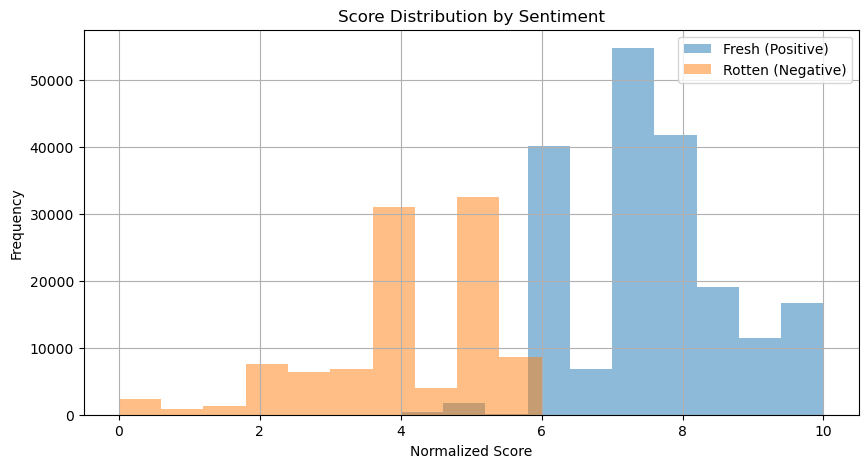

In [5]:
# Visualize the distribution of positive and negative reviews across scores
plt.figure(figsize=(10, 5))
data_final[data_final["sentiment"] == 1]["normalized_score"].hist(alpha=0.5, label="Fresh (Positive)")
data_final[data_final["sentiment"] == 0]["normalized_score"].hist(alpha=0.5, label="Rotten (Negative)")
plt.xlabel("Normalized Score")
plt.ylabel("Frequency")
plt.legend()
plt.title("Score Distribution by Sentiment")
plt.show()

In [6]:
# Training
sentiment_model = XGBClassifier(n_estimators=100)
sentiment_model.fit(X_train_s, y_train_s)
y_pred_s = sentiment_model.predict(X_test_s)
sentiment_acc = accuracy_score(y_test_s, y_pred_s)

In [7]:
score_model = XGBRegressor(n_estimators=100)
score_model.fit(X_train_r, y_train_r)
y_pred_r = score_model.predict(X_test_r)
score_mse = mean_squared_error(y_test_r, y_pred_r)

In [8]:
critic_model = CatBoostClassifier(iterations=100, verbose=0)
critic_model.fit(X_train_c, y_train_c)
y_pred_c = critic_model.predict(X_test_c)
critic_acc = accuracy_score(y_test_c, y_pred_c)

In [9]:
# Evaluation results
print(f"Sentiment Accuracy: {sentiment_acc:.2f}")
print(f"Score Prediction MSE: {score_mse:.2f}")
print(f"Critic Prediction Accuracy: {critic_acc:.2f}")

Sentiment Accuracy: 0.80
Score Prediction MSE: 2.82
Critic Prediction Accuracy: 0.77


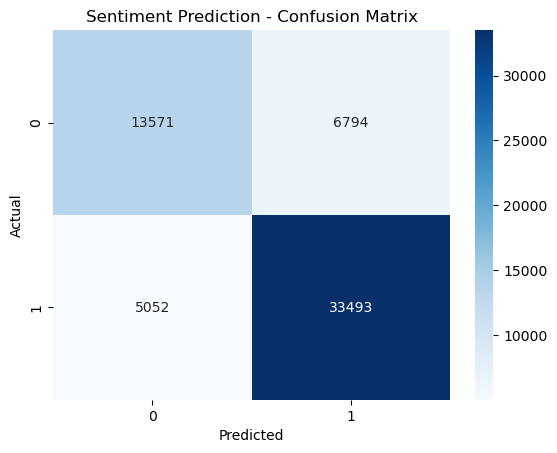

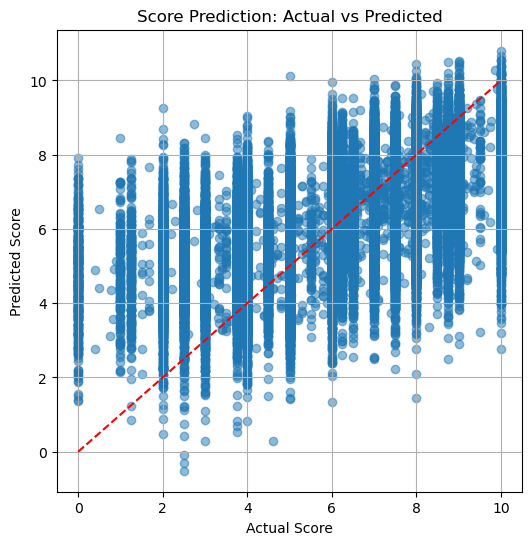

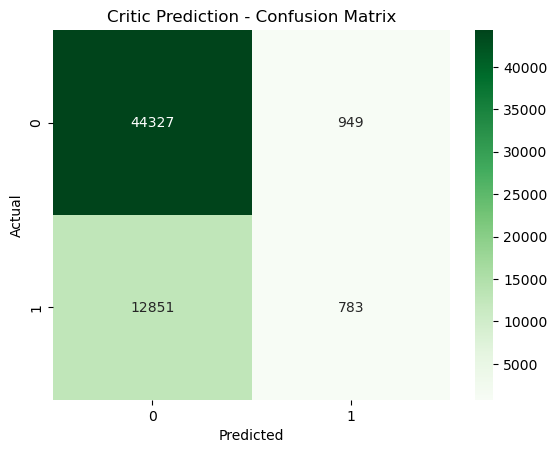


BERT Sentiment Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.67      0.70     20365
           1       0.83      0.87      0.85     38545

    accuracy                           0.80     58910
   macro avg       0.78      0.77      0.77     58910
weighted avg       0.80      0.80      0.80     58910


BERT Critic Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.98      0.87     45276
           1       0.45      0.06      0.10     13634

    accuracy                           0.77     58910
   macro avg       0.61      0.52      0.48     58910
weighted avg       0.70      0.77      0.69     58910



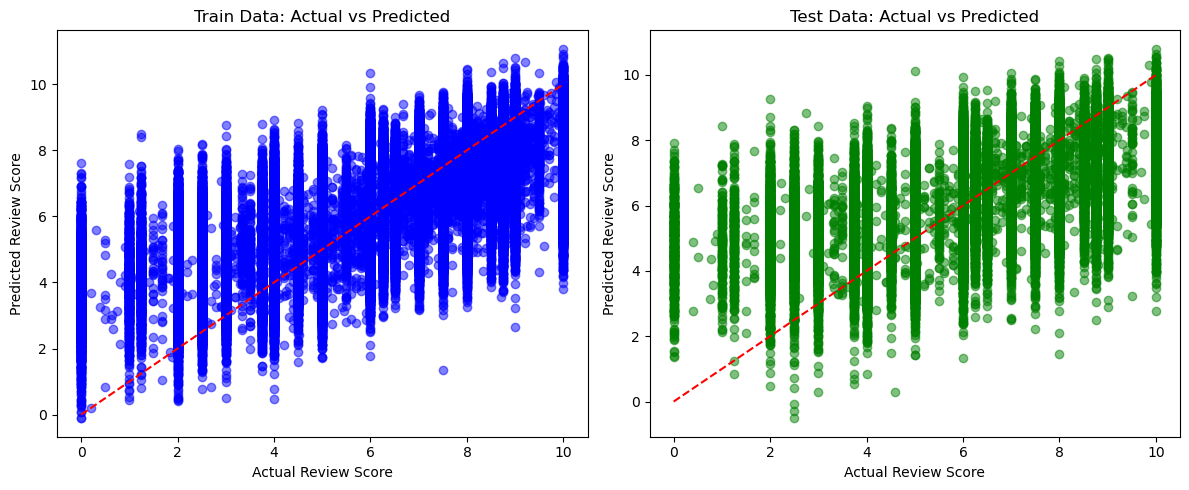

In [10]:
# Visualization: Sentiment Analysis Confusion Matrix
cm = confusion_matrix(y_test_s, y_pred_s)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Sentiment Prediction - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization: Score Prediction - Actual vs prediction
plt.figure(figsize=(6,6))
plt.scatter(y_test_r, y_pred_r, alpha=0.5)
plt.plot([0,10],[0,10],'r--')
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Score Prediction: Actual vs Predicted")
plt.grid()
plt.show()

# Visualization: Reviewers predict confusion matrix
cm_c = confusion_matrix(y_test_c, y_pred_c)
sns.heatmap(cm_c, annot=True, fmt="d", cmap="Greens")
plt.title("Critic Prediction - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classified report
print("\nBERT Sentiment Classification Report:\n")
print(classification_report(y_test_s, y_pred_s))
print("\nBERT Critic Classification Report:\n")
print(classification_report(y_test_c, y_pred_c))


y_train_pred = score_model.predict(X_train_r)
y_test_pred = score_model.predict(X_test_r)

plt.figure(figsize=(12, 5))

# Train Data
plt.subplot(1, 2, 1)
plt.scatter(y_train_r, y_train_pred, alpha=0.5, color='blue')
plt.plot([y_train_r.min(), y_train_r.max()], [y_train_r.min(), y_train_r.max()], 'r--')  # Perfect fit line
plt.xlabel("Actual Review Score")
plt.ylabel("Predicted Review Score")
plt.title("Train Data: Actual vs Predicted")

# Test Data
plt.subplot(1, 2, 2)
plt.scatter(y_test_r, y_test_pred, alpha=0.5, color='green')
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')  # Perfect fit line
plt.xlabel("Actual Review Score")
plt.ylabel("Predicted Review Score")
plt.title("Test Data: Actual vs Predicted")

plt.tight_layout()
plt.show()


In [11]:


def save_models(sentiment_model, score_model, critic_model, model_dir="models"):

    os.makedirs(model_dir, exist_ok=True)

    paths = {
        "sentiment": os.path.join(model_dir, "sentiment_xgb.joblib"),
        "score": os.path.join(model_dir, "score_xgb.joblib"),
        "critic": os.path.join(model_dir, "critic_xgb.joblib"),
    }

   
    dump(sentiment_model, paths["sentiment"])
    dump(score_model, paths["score"])
    dump(critic_model, paths["critic"])
    print(f"All models has been saved to: {model_dir}/")

    
    try:
        test_sent = load(paths["sentiment"])
        test_score = load(paths["score"])
        test_critic = load(paths["critic"])
        print("Model loaded successfully.")
    except Exception as e:
        print("Model loading failed", e)

    return paths


In [12]:
model_paths = save_models(sentiment_model, score_model, critic_model)

All models has been saved to: models/
Model loaded successfully.


In [27]:
test_reviews = pd.read_csv("newreview.csv")["review_content"]


test_series = pd.Series(test_reviews)
X_test, _, _ = get_bert_embeddings(test_series)

sentiment_model = load("models/sentiment_xgb.joblib")
score_model = load("models/score_xgb.joblib")
critic_model = load("models/critic_xgb.joblib")

sentiment_pred = sentiment_model.predict(X_test)
score_pred = score_model.predict(X_test)
critic_pred = critic_model.predict(X_test)

for i, review in enumerate(test_reviews):
    print(f"\n🎬 Review: {review}")
    print(f"   ➤ Sentiment: {'Fresh 👍' if sentiment_pred[i] else 'Rotten 👎'}")
    print(f"   ➤ Score (0-10): {score_pred[i]:.2f}")
    print(f"   ➤ Is Critic: {'Yes' if critic_pred[i] else 'No'}")


ERT: 100%|████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.53it/s]


🎬 Review: This all winds up being mindless fun with a couple of over-the-top comedic performances from Jack Black and Jason Momoa as well as a fun, visually immersive world that really springs to life on the big screen.
   ➤ Sentiment: Fresh 👍
   ➤ Score (0-10): 7.21
   ➤ Is Critic: No

🎬 Review: Based on the famous game, “A Minecraft Movie” attempts to recreate the message about the limitless power of imagination. [Full Review in Spanish]
   ➤ Sentiment: Fresh 👍
   ➤ Score (0-10): 5.73
   ➤ Is Critic: No

🎬 Review: The villain, a piglin called Malgosha who hates creativity and is obsessed with hoarding wealth, provides an inadvertently neat allegory for the studio bosses who greenlit this egregious IP cash-in.
   ➤ Sentiment: Rotten 👎
   ➤ Score (0-10): 4.72
   ➤ Is Critic: No

🎬 Review: While it may not be a masterpiece, its sheer sense of fun make it an easy win for families looking for something to watch during the holidays.
   ➤ Sentiment: Fresh 👍
   ➤ Score (0-10): 7.36
   ➤ Is 